In [1]:
import time
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelBinarizer

In [3]:
shift = 4320

In [4]:
prefix = 'C:\\Users\\rafae\\Desktop\\Coleta\\features\\features_hog_*.csv'

In [5]:
files_list = glob.glob(prefix)
print(len(files_list))

513


In [6]:
# read features
frames = [pd.read_csv(f, header=0) for f in files_list ]
len(frames)

513

In [7]:
ds = pd.concat(frames)

In [8]:
ds.shape

(7680, 17282)

In [22]:
ds.head()

,0,1,2,3,4,5,6,7,8,9,...,17272,17273,17274,17275,17276,17277,17278,17279,17280,17281
0,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071793,0.090339,0.127822,0.127822,0.042653,0.053141,0.059538,0.003019,0.019839,0.127822
1,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.069514,0.119957,0.119957,0.119957,0.024254,0.051084,0.053452,0.014108,0.010533,0.119957
2,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.103166,0.037546,0.044686,0.122575,0.033838,0.104095,0.087389,0.003405,0.009884,0.017647
3,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.132490,0.091092,0.132490,0.123109,0.038147,0.132490,0.132490,0.050142,0.042432,0.028560
4,1,p002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.052366,0.038015,0.034714,0.061695,0.040908,0.070168,0.032586,0.004734,0.009425,0.023819


In [91]:
yData = None
# IR1
#yData = ds['0']

#IR1 + IR2
yData =  pd.concat([ds['0'],ds['0']], axis=0)

groups_data =  pd.concat([ds['1'],ds['1']], axis=0)

In [83]:
xData = None
# IR1
#xData = pd.concat([ds.iloc[:,2+shift:2+shift+shift]])

#IR1 + IR2
ir1 = ds.iloc[:,2+shift:2+shift+shift]
ir2 = ds.iloc[:,2+shift+shift:2+shift+shift+shift]
print(ir1.shape, ir2.shape, type(ir1))
ir1 = ir1.transpose().reset_index(drop=True).transpose()
ir2 = ir2.transpose().reset_index(drop=True).transpose()

xData = pd.concat([ir1, ir2],axis=0,ignore_index=True)

(7680, 4320) (7680, 4320) <class 'pandas.core.frame.DataFrame'>


In [98]:
groups_data.iloc[1]

'p002'

In [84]:
print(yData.shape, xData.shape, type(yData), type(xData))

(15360,) (15360, 4320) <class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'>


In [14]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn import cross_validation

# Compute confusion matrix
def plot_confusion(yTest, yTestPred, name):
    cm = confusion_matrix(yTest, yTestPred)
    np.set_printoptions(precision=2)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    cm_normalized = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100
    print('Classification report')
    print(classification_report(yTest, yTestPred))
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix (%s)' % (name))

    plt.show()
    # plot confusion matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [85]:
from sklearn.metrics import make_scorer,precision_recall_fscore_support

def search(X_train, X_test, y_train, y_test, group_data_train):
    
    # normalize data
    print("Normalizing data!")
    stdScale = preprocessing.StandardScaler().fit(X_train)
    X_train = stdScale.transform(X_train)
    X_test = stdScale.transform(X_test)
    
    print("Grid Search Classifiers!")
    
    knc = KNeighborsClassifier()
    svc = SVC()
    rfc = RandomForestClassifier()
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
    clf1 = SVC()
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = GaussianNB()
    vt = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

    kncp = [{'n_neighbors': [3, 5, 7],
             'weights': ['uniform','distance'],
              'algorithm': ['auto','ball_tree', 'kd_tree', 'brute']}]
    svcp = [{'kernel': ['rbf'], #{'kernel': ['rbf','linear'], 
             'class_weight':['balanced'],
             'gamma': [0.0001],#['auto',1e-2, 1e-3, 1e-4],
             'C': [15]}]#[0.01, 0.1, 1.0, 1, 10, 50, 100, 500, 1000]}]
    rfcp = [{'n_estimators': [10, 20, 50, 100,200,300], 
            'max_depth': [None, 1, 10, 100],
            'bootstrap': [True, False],
            'criterion': ["gini", "entropy"]}]
    gbp = [{#'loss' : ['deviance', 'exponential'],
           'n_estimators': [50,100],
           'learning_rate': [0.1,1.0,10],
           'max_depth' : [3,5,10]
            }]
           #'min_impurity_decrease': [0.0]}]#, 0.1]}]
    vtp = [{'svc__C': [1.0, 100.0], 
            'rf__n_estimators': [20, 200],}]
   
    classifiers = [#('kNN', knc, kncp),                                 
                    ('Support Vector', svc, svcp),
                    #('Random Forest', rfc, rfcp),
                    #('Gradient Boosting', gb, gbp),
                    #('Vooting', vt, vtp)
    ]
    
    for name, classifier, params in classifiers:
        print(name)
        clf = GridSearchCV(classifier, params, cv=5, n_jobs=4, scoring=['f1_weighted','accuracy','precision_weighted', 'recall_weighted'], refit='f1_weighted' , verbose = 10)

        clf.fit(X_train, y_train, groups=group_data_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print(clf.best_score_)
        print()
        print(clf.cv_results_.keys())
        means = clf.cv_results_['mean_test_accuracy']
        stds = clf.cv_results_['std_test_accuracy']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        yTrue, yPred = y_test, clf.predict(X_test)
        print(classification_report(yTrue, yPred))
        plot_confusion(yTrue, yPred, name)
        print()

In [86]:
le = preprocessing.LabelEncoder()
le.fit(yData)
print(le.classes_)
yDataBin = le.transform(yData)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


<class 'numpy.ndarray'> (12000,) (3360,)
TRAIN: [    0     1     2 ..., 15357 15358 15359] TEST: [  570   571   572 ..., 14802 14803 14804]
['p002' 'p003' 'p005' 'p006' 'p008' 'p011' 'p012' 'p013' 'p014' 'p015'
 'p016' 'p020' 'p021' 'p022' 'p023' 'p024' 'p026' 'p027' 'p028' 'p029'
 'p030' 'p032' 'p033']
['p004' 'p007' 'p009' 'p019' 'p025' 'p031']
1     690
0     672
5     660
4     660
3     660
2     656
6     654
12    630
11    630
10    630
15    630
8     628
13    600
7     600
18    600
17    600
9     600
14    600
16    600
Name: 0, dtype: int64
17    180
16    180
2     180
6     180
8     180
10    180
12    180
14    180
18    180
1     180
3     180
5     180
7     180
9     180
11    180
13    180
0     180
15    150
4     150
Name: 0, dtype: int64


Normalizing data!
Grid Search Classifiers!
Support Vector
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed: 102.2min remaining: 153.2min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed: 102.9min remaining: 68.6min
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 149.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 149.7min finished


Best parameters set found on development set:

{'C': 15, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:
0.663580659143

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_gamma', 'param_kernel', 'params', 'split0_test_f1_weighted', 'split1_test_f1_weighted', 'split2_test_f1_weighted', 'split3_test_f1_weighted', 'split4_test_f1_weighted', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'rank_test_f1_weighted', 'split0_train_f1_weighted', 'split1_train_f1_weighted', 'split2_train_f1_weighted', 'split3_train_f1_weighted', 'split4_train_f1_weighted', 'mean_train_f1_weighted', 'std_train_f1_weighted', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy', 'split1_train_accuracy', 'split2_train_accuracy', 'split3_train_acc

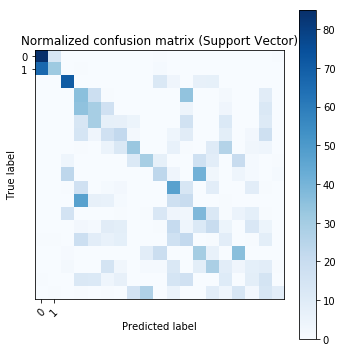


<class 'numpy.ndarray'> (12006,) (3354,)
TRAIN: [    0     1     2 ..., 15357 15358 15359] TEST: [ 1410  1411  1412 ..., 15087 15088 15089]
['p002' 'p003' 'p004' 'p005' 'p006' 'p008' 'p009' 'p011' 'p012' 'p013'
 'p014' 'p015' 'p016' 'p020' 'p023' 'p024' 'p025' 'p026' 'p027' 'p029'
 'p030' 'p031' 'p033']
['p007' 'p019' 'p021' 'p022' 'p028' 'p032']
1     690
0     672
5     660
2     660
4     660
3     660
6     654
12    630
11    630
10    630
8     630
15    630
13    600
7     600
18    600
17    600
9     600
14    600
16    600
Name: 0, dtype: int64
17    180
1     180
6     180
10    180
12    180
14    180
16    180
18    180
3     180
5     180
7     180
9     180
11    180
13    180
0     180
8     178
2     176
15    150
4     150
Name: 0, dtype: int64


Normalizing data!
Grid Search Classifiers!
Support Vector
Fitting 5 folds for each of 1 candidates, totalling 5 fits


JoblibMemoryError: JoblibMemoryError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\ProgramData\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x00000207EE587810, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x00000207EE587810, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\ProgramData\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\ProgramD...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 10, 23, 2, 17, 48, 135894, tzinfo=tzutc()), 'msg_id': 'E02F5D3F961C498D8D257733EB28F180', 'msg_type': 'execute_request', 'session': '59442CF5E8DF42BA87562F8146741319', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'E02F5D3F961C498D8D257733EB28F180', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'59442CF5E8DF42BA87562F8146741319']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 10, 23, 2, 17, 48, 135894, tzinfo=tzutc()), 'msg_id': 'E02F5D3F961C498D8D257733EB28F180', 'msg_type': 'execute_request', 'session': '59442CF5E8DF42BA87562F8146741319', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'E02F5D3F961C498D8D257733EB28F180', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'59442CF5E8DF42BA87562F8146741319'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    ', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 10, 23, 2, 17, 48, 135894, tzinfo=tzutc()), 'msg_id': 'E02F5D3F961C498D8D257733EB28F180', 'msg_type': 'execute_request', 'session': '59442CF5E8DF42BA87562F8146741319', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'E02F5D3F961C498D8D257733EB28F180', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    ', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    '
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    ',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    ',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='from sklearn.model_selection import StratifiedSh...], \n           groups_data.iloc[train_index])    ', store_history=True, silent=False, shell_futures=True)
   2693                 self.displayhook.exec_result = result
   2694 
   2695                 # Execute the user code
   2696                 interactivity = "none" if silent else self.ast_node_interactivity
   2697                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2698                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2699                 
   2700                 self.last_execution_succeeded = not has_raised
   2701 
   2702                 # Reset this so later displayed values do not modify the

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-99-a9240e2da1b6>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 2080e2f7128, executio..._before_exec=None error_in_exec=None result=None>)
   2797 
   2798         try:
   2799             for i, node in enumerate(to_run_exec):
   2800                 mod = ast.Module([node])
   2801                 code = compiler(mod, cell_name, "exec")
-> 2802                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000002080E385C00, file "<ipython-input-99-a9240e2da1b6>", line 7>
        result = <ExecutionResult object at 2080e2f7128, executio..._before_exec=None error_in_exec=None result=None>
   2803                     return True
   2804 
   2805             for i, node in enumerate(to_run_interactive):
   2806                 mod = ast.Interactive([node])

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000002080E385C00, file "<ipython-input-99-a9240e2da1b6>", line 7>, result=<ExecutionResult object at 2080e2f7128, executio..._before_exec=None error_in_exec=None result=None>)
   2857         outflag = True  # happens in more places, so it's easier as default
   2858         try:
   2859             try:
   2860                 self.hooks.pre_run_code_hook()
   2861                 #rprint('Running code', repr(code_obj)) # dbg
-> 2862                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000002080E385C00, file "<ipython-input-99-a9240e2da1b6>", line 7>
        self.user_global_ns = {'BernoulliRBM': <class 'sklearn.neural_network.rbm.BernoulliRBM'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'GroupShuffleSplit': <class 'sklearn.model_selection._split.GroupShuffleSplit'>, 'In': ['', "import time\nimport glob\nimport pandas as pd\nimpo... as plt\n\nget_ipython().magic('matplotlib inline')", 'from sklearn.ensemble import VotingClassifier\nfr...\nfrom sklearn.preprocessing import LabelBinarizer', 'shift = 4320', r"prefix = 'C:\\Users\\rafae\\Desktop\\Coleta\\features\\features_hog_*.csv'", 'files_list = glob.glob(prefix)\nprint(len(files_list))', '# read features\nframes = [pd.read_csv(f, header=0) for f in files_list ]\nlen(frames)', 'ds = pd.concat(frames)', 'ds.shape', 'ds.head()', "yData = ds['0']", 'xData = pd.concat([ds.iloc[:,2+shift:2+shift+shift]])', 'yData.iloc[20]', 'print(yData.shape, xData.shape, type(yData), type(xData))', "from sklearn.metrics import confusion_matrix\n\nde...l('True label')\n    plt.xlabel('Predicted label')", 'from sklearn.metrics import confusion_matrix\nfro...ame))\n\n    plt.show()\n    # plot confusion matrix', 'from sklearn.metrics import make_scorer,precisio...lot_confusion(yTrue, yPred, name)\n        print()', 'le = preprocessing.LabelEncoder()\nle.fit(yData)\nprint(le.classes_)\nyDataBin = le.transform(yData)', 'xData.head()', 'from sklearn.model_selection import StratifiedSh...t_index], \n           ds.iloc[train_index,1])    ', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LabelBinarizer': <class 'sklearn.preprocessing.label.LabelBinarizer'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'Out': {6: 513, 8: (7680, 17282), 9:    0     1   2   3   4   5   6   7   8   9    ......028560  
4  0.023819  

[5 rows x 17282 columns], 12: 10, 18:        4322      4323      4324      4325      4...62  0.027024  0.074032  

[5 rows x 4320 columns], 22:    0     1   2   3   4   5   6   7   8   9    ......028560  
4  0.023819  

[5 rows x 17282 columns], 25: 10, 29: 10, 48:        4322      4323      4324      4325      4...62  0.027024  0.074032  

[5 rows x 4320 columns], 51:    10000  10001  10002  10003  10004  10005  100... NaN   NaN   NaN   NaN  

[5 rows x 8640 columns], ...}, ...}
        self.user_ns = {'BernoulliRBM': <class 'sklearn.neural_network.rbm.BernoulliRBM'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'GroupShuffleSplit': <class 'sklearn.model_selection._split.GroupShuffleSplit'>, 'In': ['', "import time\nimport glob\nimport pandas as pd\nimpo... as plt\n\nget_ipython().magic('matplotlib inline')", 'from sklearn.ensemble import VotingClassifier\nfr...\nfrom sklearn.preprocessing import LabelBinarizer', 'shift = 4320', r"prefix = 'C:\\Users\\rafae\\Desktop\\Coleta\\features\\features_hog_*.csv'", 'files_list = glob.glob(prefix)\nprint(len(files_list))', '# read features\nframes = [pd.read_csv(f, header=0) for f in files_list ]\nlen(frames)', 'ds = pd.concat(frames)', 'ds.shape', 'ds.head()', "yData = ds['0']", 'xData = pd.concat([ds.iloc[:,2+shift:2+shift+shift]])', 'yData.iloc[20]', 'print(yData.shape, xData.shape, type(yData), type(xData))', "from sklearn.metrics import confusion_matrix\n\nde...l('True label')\n    plt.xlabel('Predicted label')", 'from sklearn.metrics import confusion_matrix\nfro...ame))\n\n    plt.show()\n    # plot confusion matrix', 'from sklearn.metrics import make_scorer,precisio...lot_confusion(yTrue, yPred, name)\n        print()', 'le = preprocessing.LabelEncoder()\nle.fit(yData)\nprint(le.classes_)\nyDataBin = le.transform(yData)', 'xData.head()', 'from sklearn.model_selection import StratifiedSh...t_index], \n           ds.iloc[train_index,1])    ', ...], 'KNeighborsClassifier': <class 'sklearn.neighbors.classification.KNeighborsClassifier'>, 'LabelBinarizer': <class 'sklearn.preprocessing.label.LabelBinarizer'>, 'LinearSVC': <class 'sklearn.svm.classes.LinearSVC'>, 'Out': {6: 513, 8: (7680, 17282), 9:    0     1   2   3   4   5   6   7   8   9    ......028560  
4  0.023819  

[5 rows x 17282 columns], 12: 10, 18:        4322      4323      4324      4325      4...62  0.027024  0.074032  

[5 rows x 4320 columns], 22:    0     1   2   3   4   5   6   7   8   9    ......028560  
4  0.023819  

[5 rows x 17282 columns], 25: 10, 29: 10, 48:        4322      4323      4324      4325      4...62  0.027024  0.074032  

[5 rows x 4320 columns], 51:    10000  10001  10002  10003  10004  10005  100... NaN   NaN   NaN   NaN  

[5 rows x 8640 columns], ...}, ...}
   2863             finally:
   2864                 # Reset our crash handler in place
   2865                 sys.excepthook = old_excepthook
   2866         except SystemExit as e:

...........................................................................
C:\Users\rafae\Desktop\Coleta\<ipython-input-99-a9240e2da1b6> in <module>()
     16     print()
     17     print()
     18     
     19     search(xData.iloc[train_index,:], xData.iloc[test_index,:], 
     20            yDataBin[train_index], yDataBin[test_index], 
---> 21            groups_data.iloc[train_index])    

...........................................................................
C:\Users\rafae\Desktop\Coleta\<ipython-input-85-20ace3603410> in search(X_train=array([[ 0.51,  0.53,  1.36, ..., -0.5 , -0.5 , ...[-0.42, -0.3 , -0.51, ...,  1.5 ,  0.37, -0.42]]), X_test=array([[-0.78,  0.08,  0.03, ...,  0.16, -0.26, ...[ 0.44, -0.4 ,  0.16, ..., -0.52, -0.41, -0.38]]), y_train=array([0, 0, 0, ..., 8, 8, 8], dtype=int64), y_test=array([0, 0, 0, ..., 8, 8, 8], dtype=int64), group_data_train=0     p002
1     p002
2     p002
3     p002
4   ...
14    p033
Name: 1, Length: 12006, dtype: object)
     48     
     49     for name, classifier, params in classifiers:
     50         print(name)
     51         clf = GridSearchCV(classifier, params, cv=5, n_jobs=4, scoring=['f1_weighted','accuracy','precision_weighted', 'recall_weighted'], refit='f1_weighted' , verbose = 10)
     52 
---> 53         clf.fit(X_train, y_train, groups=group_data_train)
     54 
     55         print("Best parameters set found on development set:")
     56         print()
     57         print(clf.best_params_)

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...weighted', 'recall_weighted'],
       verbose=10), X=array([[ 0.51,  0.53,  1.36, ..., -0.5 , -0.5 , ...[-0.42, -0.3 , -0.51, ...,  1.5 ,  0.37, -0.42]]), y=array([0, 0, 0, ..., 8, 8, 8], dtype=int64), groups=0     p002
1     p002
2     p002
3     p002
4   ...
14    p033
Name: 1, Length: 12006, dtype: object, **fit_params={})
    633                                   return_train_score=self.return_train_score,
    634                                   return_n_test_samples=True,
    635                                   return_times=True, return_parameters=False,
    636                                   error_score=self.error_score)
    637           for parameters, (train, test) in product(candidate_params,
--> 638                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=5, random_state=None, shuffle=False)>
        X = array([[ 0.51,  0.53,  1.36, ..., -0.5 , -0.5 , ...[-0.42, -0.3 , -0.51, ...,  1.5 ,  0.37, -0.42]])
        y = array([0, 0, 0, ..., 8, 8, 8], dtype=int64)
        groups = 0     p002
1     p002
2     p002
3     p002
4   ...
14    p033
Name: 1, Length: 12006, dtype: object
    639 
    640         # if one choose to see train score, "out" will contain train score info
    641         if self.return_train_score:
    642             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
MemoryError                                        Mon Oct 23 03:07:43 2017
PID: 15112                Python 3.6.2: C:\ProgramData\Anaconda3\python.exe
...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (SVC(C=15, cache_size=200, class_weight='balanced...None, shrinking=True,
  tol=0.001, verbose=False), memmap([[ 0.51352638,  0.52863496,  1.35661953, ... 1.50229067,
          0.37064047, -0.4228391 ]]), array([0, 0, 0, ..., 8, 8, 8], dtype=int64), {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted), 'precision_weighted': make_scorer(precision_score, pos_label=None, average=weighted), 'recall_weighted': make_scorer(recall_score, pos_label=None, average=weighted)}, array([ 2295,  2296,  2297, ..., 12003, 12004, 12005]), array([   0,    1,    2, ..., 2670, 2671, 2672]), 10, {'C': 15, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (SVC(C=15, cache_size=200, class_weight='balanced...None, shrinking=True,
  tol=0.001, verbose=False), memmap([[ 0.51352638,  0.52863496,  1.35661953, ... 1.50229067,
          0.37064047, -0.4228391 ]]), array([0, 0, 0, ..., 8, 8, 8], dtype=int64), {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted), 'precision_weighted': make_scorer(precision_score, pos_label=None, average=weighted), 'recall_weighted': make_scorer(recall_score, pos_label=None, average=weighted)}, array([ 2295,  2296,  2297, ..., 12003, 12004, 12005]), array([   0,    1,    2, ..., 2670, 2671, 2672]), 10, {'C': 15, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': True}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=SVC(C=15, cache_size=200, class_weight='balanced...None, shrinking=True,
  tol=0.001, verbose=False), X=memmap([[ 0.51352638,  0.52863496,  1.35661953, ... 1.50229067,
          0.37064047, -0.4228391 ]]), y=array([0, 0, 0, ..., 8, 8, 8], dtype=int64), scorer={'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted), 'precision_weighted': make_scorer(precision_score, pos_label=None, average=weighted), 'recall_weighted': make_scorer(recall_score, pos_label=None, average=weighted)}, train=array([ 2295,  2296,  2297, ..., 12003, 12004, 12005]), test=array([   0,    1,    2, ..., 2670, 2671, 2672]), verbose=10, parameters={'C': 15, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    432 
    433     try:
    434         if y_train is None:
    435             estimator.fit(X_train, **fit_params)
    436         else:
--> 437             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method BaseLibSVM.fit of SVC(C=15, cache_...one, shrinking=True,
  tol=0.001, verbose=False)>
        X_train = memmap([[ 0.59383984,  1.28164362,  1.12153743, ... 1.50229067,
          0.37064047, -0.4228391 ]])
        y_train = array([0, 0, 0, ..., 8, 8, 8], dtype=int64)
        fit_params = {}
    438 
    439     except Exception as e:
    440         # Note fit time as time until error
    441         fit_time = time.time() - start_time

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py in fit(self=SVC(C=15, cache_size=200, class_weight='balanced...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 0.59383984,  1.28164362,  1.12153743, ....  1.50229067,
         0.37064047, -0.4228391 ]]), y=array([ 0.,  0.,  0., ...,  8.,  8.,  8.]), sample_weight=array([], dtype=float64))
    182         fit = self._sparse_fit if self._sparse else self._dense_fit
    183         if self.verbose:  # pragma: no cover
    184             print('[LibSVM]', end='')
    185 
    186         seed = rnd.randint(np.iinfo('i').max)
--> 187         fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
        fit = <bound method BaseLibSVM._dense_fit of SVC(C=15,...one, shrinking=True,
  tol=0.001, verbose=False)>
        X = array([[ 0.59383984,  1.28164362,  1.12153743, ....  1.50229067,
         0.37064047, -0.4228391 ]])
        y = array([ 0.,  0.,  0., ...,  8.,  8.,  8.])
        sample_weight = array([], dtype=float64)
        solver_type = 0
        kernel = 'rbf'
        seed = 59518860
    188         # see comment on the other call to np.iinfo in this file
    189 
    190         self.shape_fit_ = X.shape
    191 

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py in _dense_fit(self=SVC(C=15, cache_size=200, class_weight='balanced...None, shrinking=True,
  tol=0.001, verbose=False), X=array([[ 0.59383984,  1.28164362,  1.12153743, ....  1.50229067,
         0.37064047, -0.4228391 ]]), y=array([ 0.,  0.,  0., ...,  8.,  8.,  8.]), sample_weight=array([], dtype=float64), solver_type=0, kernel='rbf', random_seed=59518860)
    249                 class_weight=self.class_weight_, kernel=kernel, C=self.C,
    250                 nu=self.nu, probability=self.probability, degree=self.degree,
    251                 shrinking=self.shrinking, tol=self.tol,
    252                 cache_size=self.cache_size, coef0=self.coef0,
    253                 gamma=self._gamma, epsilon=self.epsilon,
--> 254                 max_iter=self.max_iter, random_seed=random_seed)
        self.max_iter = -1
        random_seed = 59518860
    255 
    256         self._warn_from_fit_status()
    257 
    258     def _sparse_fit(self, X, y, sample_weight, solver_type, kernel,

...........................................................................
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\libsvm.cp36-win_amd64.pyd in sklearn.svm.libsvm.fit()

MemoryError: 
___________________________________________________________________________

In [99]:
from sklearn.model_selection import StratifiedShuffleSplit,GroupShuffleSplit
from scipy import stats

#gss = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=0)
gss = GroupShuffleSplit(n_splits=2, test_size=0.20, random_state=10)

for train_index, test_index in gss.split(xData, yDataBin, groups=groups_data):
    print(type(train_index), train_index.shape, test_index.shape)
    print("TRAIN:", train_index, "TEST:", test_index)
    print(np.unique(groups_data.iloc[train_index]))
    print(np.unique(groups_data.iloc[test_index]))
    dt = pd.DataFrame(yDataBin[train_index])
    print(dt[0].value_counts())
    dte = pd.DataFrame(yDataBin[test_index])
    print(dte[0].value_counts())
    print()
    print()
    
    search(xData.iloc[train_index,:], xData.iloc[test_index,:], 
           yDataBin[train_index], yDataBin[test_index], 
           groups_data.iloc[train_index])    

In [ ]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(xData, yDataBin, test_size=0.3, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape,
      type(X_train.shape), type(X_test.shape), type(y_train.shape), type(y_test.shape))

In [ ]:
search(X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(nds.iloc[:,2:])
nnds = pca.transform(nds.iloc[:,2:])